## Logisitc Regression (No hyperparameter tuning and cross validation)

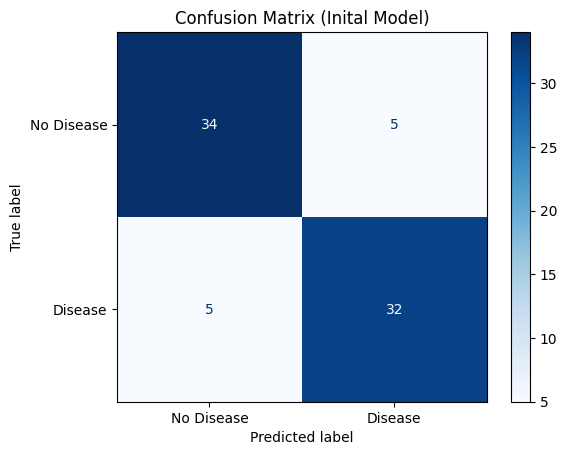

Logistic Regression Accuracy: 0.868421052631579
Precision: 0.86
Recall (Sensitivity): 0.86
Specificity: 0.87
F1-Score: 0.86
ROC-AUC: 0.92


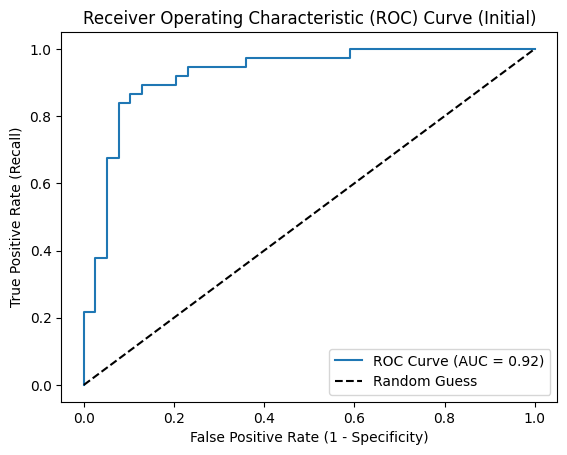

In [16]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# extract data and target
X = heart_disease.data.features  # Features
y = heart_disease.data.targets   # Target variable

# targets that are 1-4, are now just equal to 1.
y = (y > 0).astype(int)

# select the 13 features (update these indices or column names based on the dataset)
selected_features = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal"
]

# using only the selected features
X = X[selected_features]

# handle missing values by imputing them with the column mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# split dataset into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# this ensures that y_train and y_test are 1D
y_train = y_train.values.ravel()  # Convert to numpy array and flatten
y_test = y_test.values.ravel()

# apply min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# initialize and train Logistic Regression model
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_scaled, y_train)

# predictions on test dataset
y_pred_log_reg = log_reg_model.predict(X_test_scaled)

# generate and display Confusion Matrix
ConfusionMatrixDisplay.from_estimator(log_reg_model, X_test_scaled, y_test, display_labels=["No Disease", "Disease"], cmap="Blues")
plt.title("Confusion Matrix (Inital Model)")
plt.show()

# calculate and display accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print("Logistic Regression Accuracy:", accuracy_log_reg)

# calculate Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

# TN, FP, FN, TP from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log_reg).ravel()

# calculate Specificity
specificity = tn / (tn + fp)

# print all metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")

# ROC-AUC Score (might be unnecessary)
y_pred_prob = log_reg_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.2f}")

# plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve (Initial)")
plt.legend(loc="best")
plt.show()

# save results for the initial model
initial_model_results = {}

# store predictions and metrics for later comparison
initial_model_results['fpr'], initial_model_results['tpr'], initial_model_results['thresholds'] = roc_curve(y_test, y_pred_prob)
initial_model_results['roc_auc'] = roc_auc
initial_model_results['precision'] = precision
initial_model_results['recall'] = recall
initial_model_results['f1'] = f1
initial_model_results['specificity'] = specificity


## Logistic Regression Model (Cross validation and hyperparameter tuning)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.8371014492753623
Precision: 0.89
Recall (Sensitivity): 0.86
Specificity: 0.90
F1-Score: 0.88
ROC-AUC: 0.91


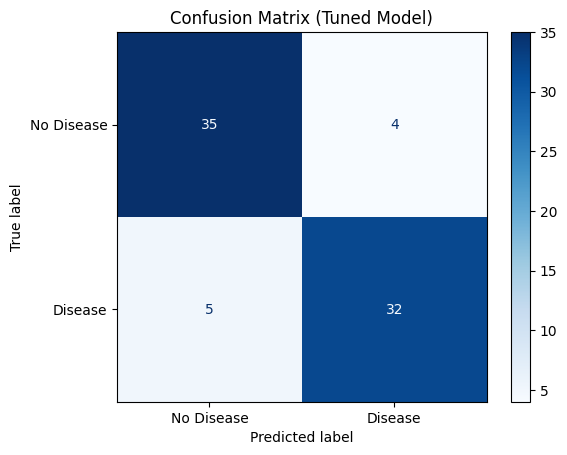

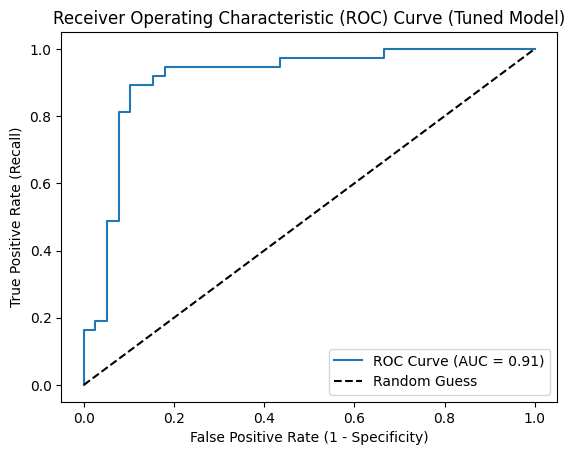

In [17]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# extract data and target
X = heart_disease.data.features  # Features
y = heart_disease.data.targets   # Target variable

# targets that are 1-4, are now just equal to 1.
y = (y > 0).astype(int)

# select the 13 features (update these indices or column names based on the dataset)
selected_features = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal"
]

# using only the selected features
X = X[selected_features]

# handle missing values by imputing them with the column mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# split dataset into 75% training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ensure y_train and y_test are 1D
y_train = y_train.values.ravel()  # convert to numpy array and flatten
y_test = y_test.values.ravel()

# apply min-max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support both penalties
}

# initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000)

# perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# print the best parameters and best cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# train the best model on the full training data
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# predictions on test dataset
y_pred_log_reg = best_model.predict(X_test_scaled)

# calculate and display metrics
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

# TN, FP, FN, TP from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_log_reg).ravel()
specificity = tn / (tn + fp)

# print all metrics
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# generate and display Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test, display_labels=["No Disease", "Disease"], cmap="Blues")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

# plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve (Tuned Model)")
plt.legend(loc="best")
plt.show()